# Evaluating a model

This notebook demonstrates evaluating a trained model by exploring the results on the independent set of data, and displaying the training process.

It is important to explore more than the loss produced during training in order to evaluate a model. Especially in the context of ML applied to science where it is not common that the underlying task to solve is "minimize the RMSE" and instead more likely to be "Predict the height layer level of a cloud base" where root mean square error between the desired output and the model output can help to understand how well the underlying task is going, more evaluation is required for a better picture of the model.

Evaluation is explored through recalling the training process, producing classical metrics, as well as custom metrics designed for the current task (in our case SEDI and SEDS). More evaluation could be considered in order to explore the exact cases in which the model fails or implementing techniques for explainability of the model for better interpretation of the results.

additionally, some testing of bespoke evaluation to ensure refactoring from the base solution is consistent with previous implementations of evaluation is performed

Ideally the result of an evaluation that comes after the minimum ml pipeline is built and during model development will be to address issues with the model performance using methods informed by the evaluation. Methods can refer to a number of techniques: changes to model architecture, testing different training data sampling techniques, or reframing the ML task to enforce more robust output from the model, are some examples.

### Environment

This notebook is intended to be run in the py-lightning-cbh conda environment defined in requirements_torch.yml

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
import zarr
from sklearn.metrics import confusion_matrix

import cbh_data_definitions
import cbh_torch_lstm  # defined in directory (model definition)
import cbh_torch_MLP

## Define and initialize the evaluation data

In [2]:
root_data_directory = pathlib.Path(os.environ["DATADIR"]) / "cbh_data"
test_data_path = (
    root_data_directory / "analysis_ready" / "dev.zarr"
)  # must change with available test data

In [3]:
test_input, test_labels, test_cloud_volume = cbh_data_definitions.load_data_from_zarr(
    test_data_path
)
print(test_labels.chunksize[0])
print(len(test_labels))

Loaded zarr, file information:
 Name              : /
Type              : zarr.hierarchy.Group
Read-only         : False
Synchronizer type : zarr.sync.ThreadSynchronizer
Store type        : zarr.storage.DirectoryStore
No. members       : 3
No. arrays        : 3
No. groups        : 0
Arrays            : cloud_base_label_y.zarr, cloud_volume_fraction_y.zarr,
                  : humidity_temp_pressure_x.zarr
 

102400
307200


In [4]:
collate_fn = cbh_data_definitions.dataloader_collate_with_dask
batch_size = int(test_labels.chunksize[0] / 16)
workers_on_system = 0
CPU_COUNT = 4
data_loader_hparam_dict = {
    "batch_size": batch_size,
    "num_workers": workers_on_system,
    "pin_memory": False,
    "collate_fn": collate_fn,
}
test_dataset = cbh_data_definitions.CBH_Dataset_Load_One_Chunk(
    test_input, test_labels, threads=CPU_COUNT
)

In [5]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, **data_loader_hparam_dict)

## Recall a trained model, for this step a particular mlflow experiment is chosen from mlflow_artifacts to evaluate (defined in the cell below)

Below is the selection of the trained model that we want to evaluate, in this case we should take the final checkpoint from our initial training run to help spot any errors.

MLFlow allows saving of artifacts for each run, and creates a hash (acting as a unique identifier), we find where the model artifact has been saved to specify the model path

In [6]:
model_run_hash = "6fe61152e8374f348cf9ce75e7a4b17e"
checkpoint_path = "./mlruns/3/6fe61152e8374f348cf9ce75e7a4b17e/artifacts/2022-12-08 00:49:17.641711best_model_checkpoint-step_425013.pt"

In [7]:
chkpt = torch.load(checkpoint_path)
print(chkpt.keys())

dict_keys(['val loss', 'global_step', 'model_state_dict', 'checkpoint'])


In [8]:
ckpt_instead_of_model_weights = False
if ckpt_instead_of_model_weights:
    model = cbh_torch_lstm.CloudBaseLSTM.load_from_checkpoint(checkpoint_path)
else:
    from tempfile import TemporaryDirectory

    with TemporaryDirectory() as tmpdirname:
        tempfile = tmpdirname + "/ckhpt"
        torch.save(chkpt["checkpoint"], tempfile)
        model = cbh_torch_lstm.CloudBaseLSTM.load_from_checkpoint(tempfile)
        # model = cbh_torch_MLP.CloudBaseMLP.load_from_checkpoint(tempfile)
model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v1.9.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../../../var/tmp/tmp0yjfxsc7/ckhpt`


CloudBaseLSTM(
  (LSTM_upward): LSTM(23, 100, num_layers=2, batch_first=True, bidirectional=True)
  (height_embedding): Embedding(70, 20)
  (loss_fn_base): CrossEntropyLoss()
  (scale_input_layer): Conv1d(23, 100, kernel_size=(1,), stride=(1,))
  (cap_layer): Linear(in_features=7000, out_features=70, bias=True)
)

## Get model predictions for Eval

loop through all of the test data, collecting the targets and the model predictions.

In [9]:
VERIFY_FUNCTION_CORRECTNESS = True

MLP = False
LSTM = True

In [10]:
%%time
all_preds = np.empty(0)
all_targs = np.empty(0)
for i, sample_batch in enumerate(test_dataloader):
    all_targs = np.concatenate((all_targs, sample_batch[1]), axis=0)
    x = sample_batch[0]
    # x = torch.flatten(x, start_dim=1)
    with torch.no_grad():
        batch_preds = model(x)  # self call = forward
    class_prediction = np.argmax(batch_preds.detach().numpy(), axis=1)
    all_preds = np.concatenate(
        (all_preds, class_prediction), axis=0
    )  # get second value only (since model doesn't support the other return per how it is currently defined)

print("Length of prediction output:", all_preds.shape)

print("Prediction output matches target output:", all_targs.shape == all_preds.shape)

/net/home/h02/hsouth/github_committing/data_science_cop/challenges/2021_cloud_base_height/cbh_torch_lstm.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  height = torch.tensor(torch.arange(0,70)).repeat((len(x),1)).reshape(len(x),70,1)


Length of prediction output: (307200,)
Prediction output matches target output: True
CPU times: user 30min 55s, sys: 5min 42s, total: 36min 37s
Wall time: 7min 10s


Here a small subset of predictions and targets are given to give the reader an idea of the kind of outputs that come about for the task, then the outputs and targets are binned for a better idea of how the model operates. Due to the class imbalance of our task, it is likely that the model will overpredict the majority classes (0 and 69).

In [11]:
print("Show of some predictions :", all_preds[0:20])
print("Show of some targets, same samples:", all_targs[0:20])
print(
    "Model predictions binned: (Class labels), (Counts):",
    np.unique(all_preds, return_counts=True),
)
print(
    "Target labels binned: (Class labels), (Counts):",
    np.unique(all_targs, return_counts=True),
)
print("Accuracy:", np.count_nonzero(all_preds == all_targs) / len(all_preds))

Show of some predictions : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Show of some targets, same samples: [16. 15. 15. 15. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16.]
Model predictions binned: (Class labels), (Counts): (array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 69.]), array([61321,  4095,  3792,  7198,  5859,  5680,  6126,  9070,  7355,
        7091,  8283,  8359,  6973,  8085,  4774,  4193,  3949,  2400,
        3081,  2510,  2311,  1788,  1517,  2446,  3966,  4163,  2099,
        2768,  3309,  1865,  2663,  1934,  2263,  2798,  3028,  2874,
        3052,  3298,  3308,  3650,  2646,  2511,  1736,  1430,   717,
          62,     1, 72803]))
Target labels binned: (Class labels), (Counts): (array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.

Binning the class predictions can help to diagnose model issues, more thought will have to be given to a model that only predicts a single class, perhaps: weighting the loss on minority class, choosing a different sampling method on the training data, changing the model architecture, or reframing the machine learning input and outputs which can then later be translated to the desired task.

## Evaluate model returns

Next, more bespoke evaluation is performed using the metric of SEDI and SEDS for each height layer in the sample as well as more classical metrics: Accuracy, Mean Error, Mean Absolute Error, Root Mean Squared Error

I have tried to speed up the execution of the SEDS and SEDI evaluation by having the functions used in the base solution of the cbh challenge here to verify their correctness through comparing my refactored functions with the old function on a couple test-cases. I also report the time of the execution to justify this effort

In [12]:
def old_cbh_eval(preds, targs):
    # for all tested height layers
    abcd_list = []
    for k in np.arange(0, 53, 1):
        a = 0.0
        b = 0.0
        c = 0.0
        d = 0.0
        for i in np.arange(0, targs.shape[1]):
            # Is the cloud-base at this level or below.
            if targs[0, i] <= np.float64(k) and preds[0, i] <= np.float64(k):
                # Hit
                a = a + 1.0
            elif targs[0, i] > np.float64(k) and preds[0, i] <= np.float64(k):
                # False alarm
                b = b + 1.0
            elif targs[0, i] <= np.float64(k) and preds[0, i] > np.float64(k):
                # Miss
                c = c + 1.0
            else:
                # Correct negative
                d = d + 1.0
        if a == 0.0 or b == 0.0:
            a += 1
            b += 1
        abcd_list.append((a, b, c, d))
    return abcd_list

In [13]:
import typing
# new function
def new_cbh_eval(preds: typing.Iterable, targs: typing.Iterable, test_before_layer=53):

    batch_length = len(targs)
    cloud_height_expanded_array = np.column_stack(
        np.arange(test_before_layer)
    ).T.repeat(batch_length, 1)
    p = targs <= cloud_height_expanded_array
    q = preds <= cloud_height_expanded_array

    a = p & q
    b = np.logical_not(p) & q
    c = p & np.logical_not(q)
    d = np.logical_not(a | b | c)
    adjust = np.logical_not(a.any(1) & b.any(1))

    l = lambda x: x.sum(1)
    return list(
        zip(
            (np.where(adjust, l(a) + 1, l(a))),
            (np.where(adjust, l(b) + 1, l(b))),
            l(c),
            l(d),
        )
    )

In [14]:
# Test function equivalance
aa = [0, 1, 2, 3, 4, 4, 1]
bb = [0, 3, 1, 4, 1, 4, 1]
if VERIFY_FUNCTION_CORRECTNESS:
    print(
        "Equiv. function on test subset?:",
        new_cbh_eval(all_preds[0:2000], all_targs[0:2000])
        == old_cbh_eval(np.array([all_preds[0:2000]]), np.array([all_targs[0:2000]])),
    )
    print(
        "Equiv. function on toy data?:",
        new_cbh_eval(aa, bb) == old_cbh_eval(np.array([aa]), np.array([bb])),
    )
    print("Time on new function, test data:", end=" ")
    %timeit new_cbh_eval(all_preds, all_targs)
    print("Time on old function, test data:", end=" ")
    %timeit old_cbh_eval(np.array([all_preds]), np.array([all_targs]))
    print("Time on new function, toy data:", end=" ")
    %timeit new_cbh_eval(aa, bb)
    print("Time on old function, toy data:", end=" ")
    %timeit old_cbh_eval(np.array([aa]), np.array([bb]))

Equiv. function on test subset?: True
Equiv. function on toy data?: True
Time on new function, test data: 179 ms ± 536 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time on old function, test data: 15.9 s ± 88.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time on new function, toy data: 186 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Time on old function, toy data: 501 µs ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
abcd_list = new_cbh_eval(all_preds, all_targs)  # save the eval result

In [16]:
def calc_sedi_from_abcd_list(abcd_list):
    store_sedi, store_seds = ([], [])
    for a, b, c, d in abcd_list:
        n = a + b + c + d
        ar = ((a + b) * (a + c)) / n
        # Symmetric Extreme Dependency Score (SEDS) has advantage that it is 1.0 for perfect forecast
        # and 0.0 for no better than climatology
        # (unlike Equitable Threat Score [ETS] for which it is not clear at what point a low score means it is poor.
        seds = np.log(ar / a) / np.log(a / n)
        store_seds = np.append(store_seds, seds)
        # Also calculate SEDI from Ferro and Stephenson (equation 2)
        # https://journals.ametsoc.org/view/journals/wefo/26/5/waf-d-10-05030_1.xml
        h = a / (a + c)
        f = b / (b + d)
        top = np.log(f) - np.log(h) - np.log(1.0 - f) + np.log(1.0 - h)
        bottom = np.log(f) + np.log(h) + np.log(1.0 - f) + np.log(1.0 - h)
        sedi = top / bottom
        store_sedi = np.append(store_sedi, sedi)

    return store_sedi, store_seds

In [17]:
def calc_sedi_numpy(abcd_list):

    sed_arr = np.array(abcd_list)
    n = np.sum(sed_arr, axis=1)
    a = sed_arr[:, 0]
    b = sed_arr[:, 1]
    c = sed_arr[:, 2]
    d = sed_arr[:, 3]
    ar = ((a + b) * (a + c)) / n
    seds = np.log(ar / a) / np.log(a / n)

    h = a / (a + c)
    f = b / (b + d)
    top = np.log((f * (1.0 - h)) / (h * (1.0 - f)))
    bottom = np.log(f * h * (1.0 - f) * (1.0 - h))
    sedi = top / bottom

    return sedi, seds

In [18]:
# perform the same equiv. test but for sedi calculation from previous function output
sedi_list_new, seds_list_new = calc_sedi_numpy(abcd_list)
sedi_list_old, seds_list_old = calc_sedi_from_abcd_list(abcd_list)
if VERIFY_FUNCTION_CORRECTNESS:
    print("Equiv. function for SEDS?:", np.array_equal(seds_list_new, seds_list_old))
    print(
        "Equiv. function for SEDI? (possible differences of approx. 1e-16):",
        np.array_equal(sedi_list_new, sedi_list_old),
    )
    # it turns out using the property of logarithms to shorten the top/bottom sedi calculation creates differences at the 1e-16 or 1e-17 decimal
    print(
        "Close function for SEDI? (absolute tolerance 1e-15):",
        np.allclose(sedi_list_new, sedi_list_old, rtol=0, atol=1e-15),
    )
    print(
        "Closer function for SEDI? (absolute tolerance 1e-16):",
        np.allclose(sedi_list_new, sedi_list_old, rtol=0, atol=1e-16),
    )
    print("Time on new function, test data:", end=" ")
    %timeit calc_sedi_numpy(abcd_list)
    print("Time on old function, test data:", end=" ")
    %timeit calc_sedi_from_abcd_list(abcd_list)

Equiv. function for SEDS?: True
Equiv. function for SEDI? (possible differences of approx. 1e-16): False
Close function for SEDI? (absolute tolerance 1e-15): True
Closer function for SEDI? (absolute tolerance 1e-16): False
Time on new function, test data: 62.1 µs ± 44.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Time on old function, test data: 1.2 ms ± 7.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
sedi_score = np.mean(sedi_list_new)
seds_score = np.mean(seds_list_new)

In [20]:
prediction_difference = all_preds - all_targs # elementwise subtraction of the matrices
print("Accuracy:", np.count_nonzero(all_preds == all_targs) / len(all_preds))
print("Mean Error:", np.mean(prediction_difference))
print("Mean Absolute Error:", np.mean(np.abs(prediction_difference)))
print("Root Mean Squared Error:", np.sqrt(np.mean((prediction_difference) ** 2.0)))
print("SEDI:", sedi_score)
print("SEDS:", seds_score)

Accuracy: 0.7237760416666666
Mean Error: -0.7226790364583333
Mean Absolute Error: 3.4119368489583333
Root Mean Squared Error: 11.786159040241863
SEDI: 0.9604880251062312
SEDS: 0.8328676329262464


The metrics above are not a catch-all for model issues, but do well when making comparisons to previous models (models previously trained by both the developer and reported metrics from other developers who have tackled the ml-challenge). Most notably, accuracy becomes a poor metric for evaluating model performance with class imbalance.

## Present Evaluation Plots

Accuracy and Error are common metrics for evaluating model performances across all domains, however in classification problems, a confusion matrix is also provided to give a better idea of the class imblances of both the data and the model imbalance as a visual extension to the class binnings above.

First confusion can be simplified to correct, higher, or lower. Then more detail can be added by visualizing the bins for every class in predictions vs targets

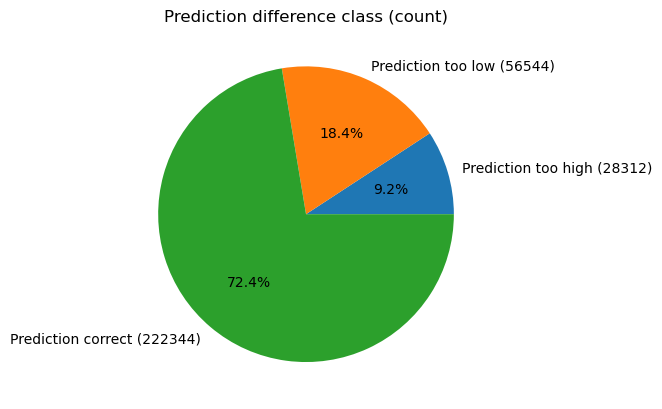

In [21]:
prediction_higher_than_target = np.count_nonzero(all_preds > all_targs)
prediction_lower_than_target = np.count_nonzero(all_preds < all_targs)
prediction_equal_to_target = np.count_nonzero(all_preds == all_targs)
labels = [
    f"Prediction too high ({prediction_higher_than_target})",
    f"Prediction too low ({prediction_lower_than_target})",
    f"Prediction correct ({prediction_equal_to_target})",
]

plt.pie(
    [
        prediction_higher_than_target,
        prediction_lower_than_target,
        prediction_equal_to_target,
    ],
    labels=labels,
    autopct="%1.1f%%",
)
plt.title("Prediction difference class (count)")
plt.show()

A visual show of the accuracy and then binning the incorrect predictions may give some further information around how the model fails

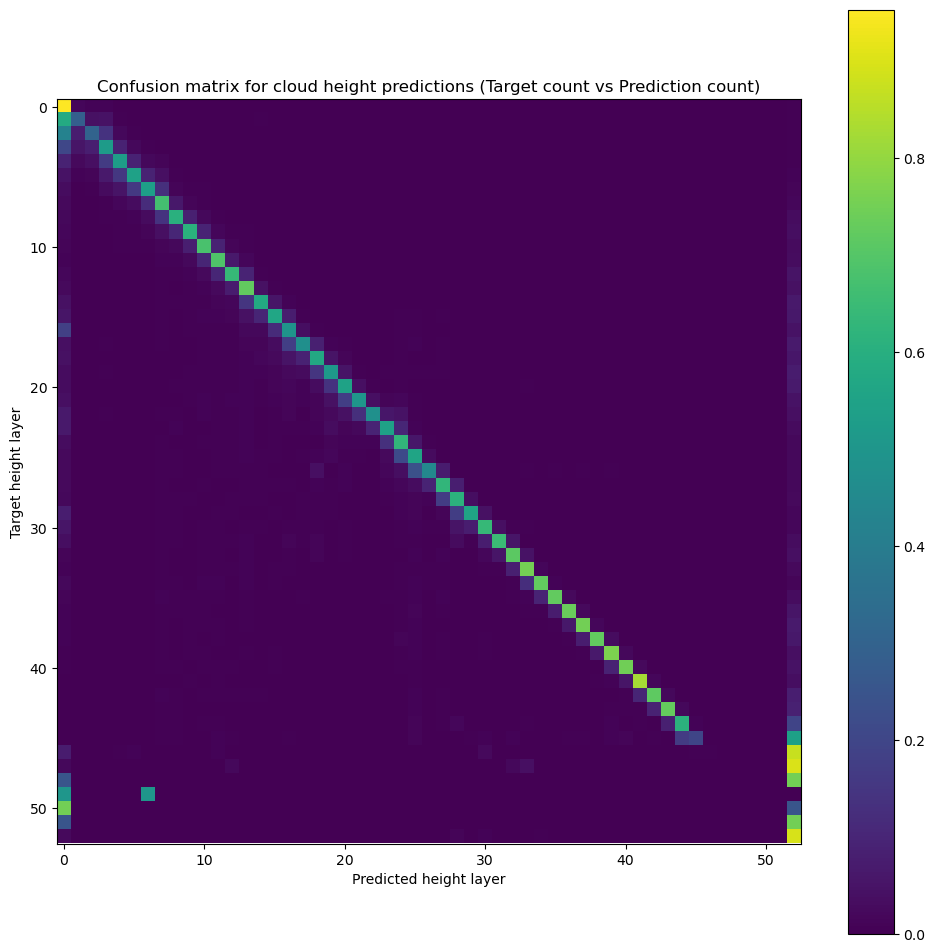

In [22]:
# sedi like a,b,d,c mean confusion matrix

plt.figure(figsize=(12, 12))

confm = confusion_matrix(all_targs, all_preds, normalize="true")
plt.imshow(confm, cmap=plt.cm.viridis, interpolation="nearest")
plt.colorbar()
plt.title(
    "Confusion matrix for cloud height predictions (Target count vs Prediction count)"
)
plt.ylabel("Target height layer")
plt.xlabel("Predicted height layer")
plt.show()

In [23]:
labels, counts = np.unique(all_preds, return_counts=True)
bins_pred = tuple(zip(list(labels), list(counts)))
labels, counts = np.unique(all_targs, return_counts=True)
bins_targ = tuple(zip(list(labels), list(counts)))
print("\nModel predictions binned: (Class label, Count):", bins_pred, "\n")
print("Target labels binned: (Class label, Count):", bins_targ)


Model predictions binned: (Class label, Count): ((0.0, 61321), (1.0, 4095), (2.0, 3792), (3.0, 7198), (4.0, 5859), (5.0, 5680), (6.0, 6126), (7.0, 9070), (8.0, 7355), (9.0, 7091), (10.0, 8283), (11.0, 8359), (12.0, 6973), (13.0, 8085), (14.0, 4774), (15.0, 4193), (16.0, 3949), (17.0, 2400), (18.0, 3081), (19.0, 2510), (20.0, 2311), (21.0, 1788), (22.0, 1517), (23.0, 2446), (24.0, 3966), (25.0, 4163), (26.0, 2099), (27.0, 2768), (28.0, 3309), (29.0, 1865), (30.0, 2663), (31.0, 1934), (32.0, 2263), (33.0, 2798), (34.0, 3028), (35.0, 2874), (36.0, 3052), (37.0, 3298), (38.0, 3308), (39.0, 3650), (40.0, 2646), (41.0, 2511), (42.0, 1736), (43.0, 1430), (44.0, 717), (45.0, 62), (46.0, 1), (69.0, 72803)) 

Target labels binned: (Class label, Count): ((0.0, 48207), (1.0, 7345), (2.0, 6824), (3.0, 6581), (4.0, 6311), (5.0, 5855), (6.0, 6811), (7.0, 8105), (8.0, 8406), (9.0, 7745), (10.0, 8055), (11.0, 8211), (12.0, 7782), (13.0, 7082), (14.0, 5604), (15.0, 4535), (16.0, 4367), (17.0, 3159), (1

The binned model predictions show in a class by class confusion matrix can be the most useful of the evaluation methods. In the case of this challenge, it will be a common issue for the model to make incorrect predictions for the cloud base targets at the highest of layers (approx 44+), this is because in the training data there are few samples in these higher layers to train from.

It is possible to have a look at the individual layers of the shown confusion matrix to get a better idea of where the predictions have ended up instead of the correct class:

In [24]:
print(confm.shape)
label_index = 46
print("\n Percentage of predictions predicted at a single label height for each class\n", confm[:, label_index])
print("\n distribution of height predictions for a single label height:\n", confm[label_index])

(53, 53)

 Percentage of predictions predicted at a single label height for each class
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00471698 0.
 0.         0.         0.         0.         0.        ]

 distribution of height predictions for a single label height:
 [0.07075472 0.         0.         0.         0.00471698 0.00943396
 0.         0.         0.         0.         0.         0.00943396
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0235

individual class matrices can be explored with their exact values by printing out the column/row of the matrix

In the below plot the classes from the SED evaluation are summed across the layer axis, and then compared in a plot, aiming to discover where the model is most likely to fail

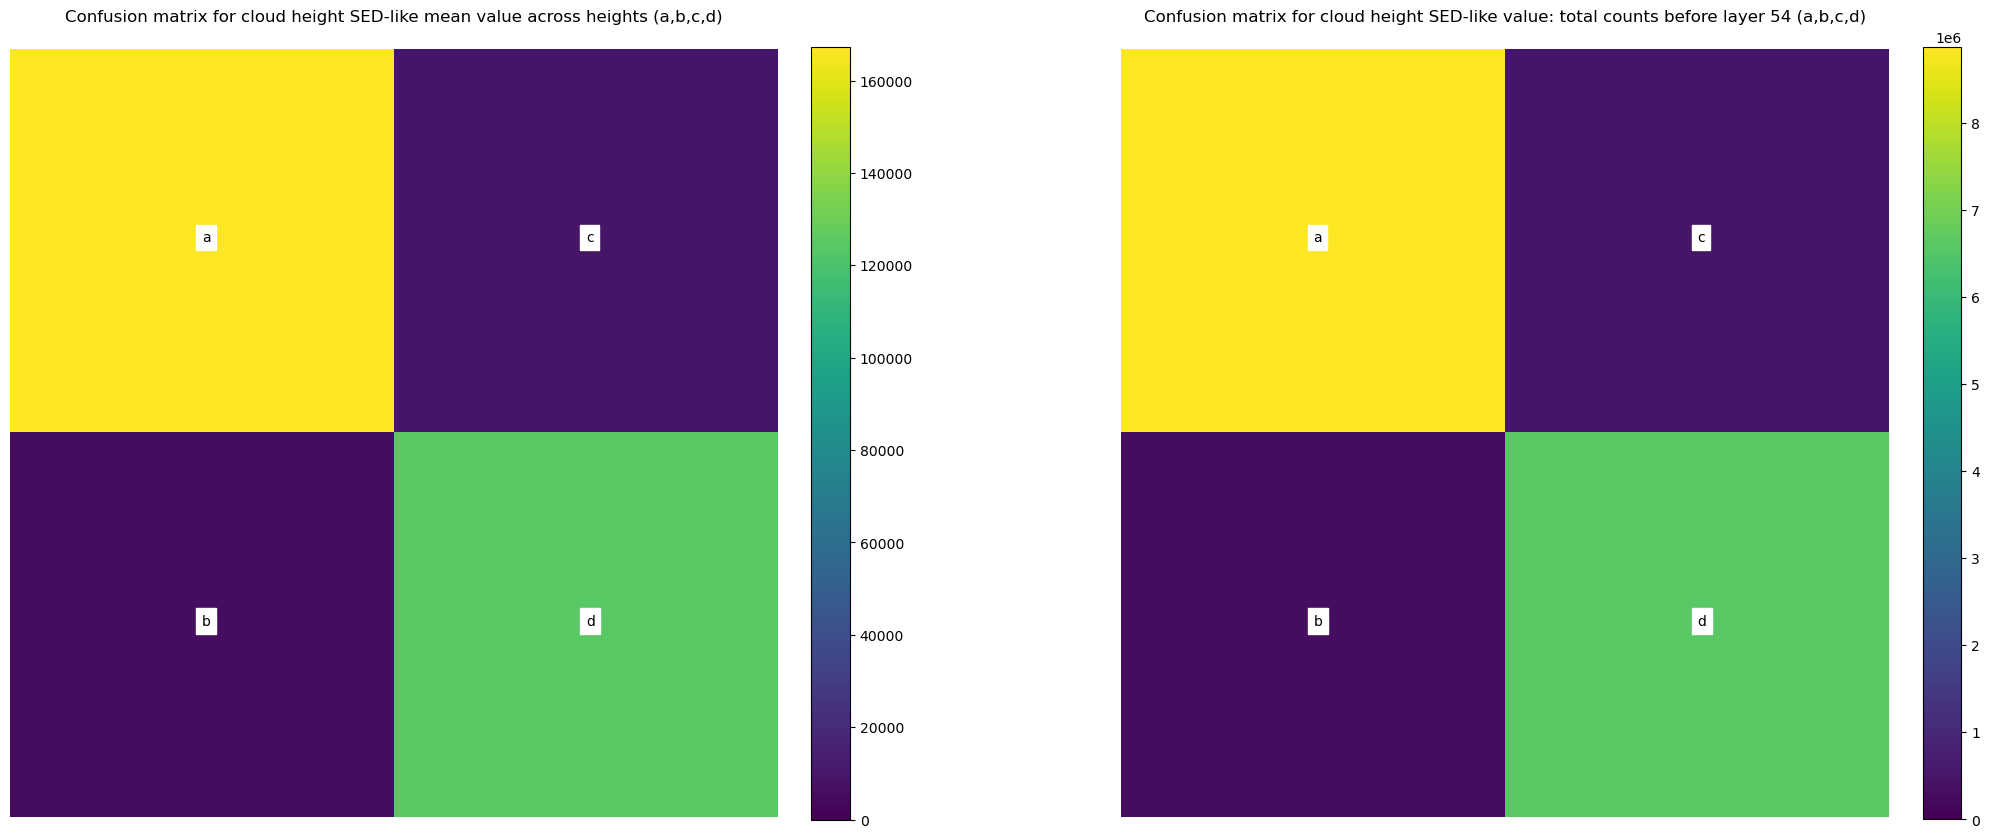

In [25]:
sed_like_conf_matrix = np.reshape(np.mean(np.array(abcd_list).T, axis=1), (2, 2))
labels = ["a", "b", "c", "d"]
fig = plt.figure(figsize=(20, 24))

from matplotlib import colors

divnorm = colors.Normalize(vmin=0.0)
divnorm2 = colors.Normalize(vmin=0.0)

ax1 = fig.add_subplot(121)
im = ax1.imshow(
    sed_like_conf_matrix, cmap=plt.cm.viridis, interpolation="nearest", norm=divnorm
)
for i, lab in enumerate(labels):
    ax1.text(i // 2, i % 2, lab, backgroundcolor="white")
plt.colorbar(im, fraction=0.046, pad=0.04)
ax1.axis("off")
plt.title(
    "Confusion matrix for cloud height SED-like mean value across heights (a,b,c,d)",
    pad=20,
)


sed_like_conf_matrix_counts = np.reshape(
    np.sum(np.array(abcd_list[0:54]).T, axis=1), (2, 2)
)
ax2 = fig.add_subplot(122)
im2 = ax2.imshow(
    sed_like_conf_matrix_counts,
    cmap=plt.cm.viridis,
    interpolation="nearest",
    norm=divnorm2,
)
for i, lab in enumerate(labels):
    ax2.text(i // 2, i % 2, lab, backgroundcolor="white")
plt.colorbar(im2, fraction=0.046, pad=0.04)
ax2.axis("off")
plt.title(
    "Confusion matrix for cloud height SED-like value: total counts before layer 54 (a,b,c,d)",
    pad=20,
)
plt.tight_layout(w_pad=15)

plt.show()

## Finally, show some training info for this experiment

In [26]:
# init mlflow connection
mlflow_server_address = "vld425"
mlflow_server_port = 5001
mlflow_server_uri = f"http://{mlflow_server_address}:{mlflow_server_port:d}"
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri=mlflow_server_uri)

In [27]:
print(mlflow_client.search_experiments())

MlflowException: API request to http://vld425:5001/api/2.0/mlflow/experiments/search failed with exception HTTPConnectionPool(host='webproxy.metoffice.gov.uk', port=8080): Max retries exceeded with url: http://vld425.cmpd1.metoffice.gov.uk/api/2.0/mlflow/experiments/search (Caused by ResponseError('too many 503 error responses'))

In [ ]:
experiment_id = 3
runs = mlflow_client.search_runs(experiment_ids=experiment_id)
desired_run = [run for run in runs if run.info.run_id == model_run_hash][0]
print("Run metrics:", desired_run.data.metrics)
print("\nRun Hyperparams:", desired_run.data.params)

In [ ]:
reshp_preds = all_preds.reshape(480, 640)
reshp_targ = all_targs.reshape(480, 640)
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
plt.title("Predictions (as map)")
pos1 = ax1.imshow(reshp_preds)

ax2 = fig.add_subplot(122)
plt.title("Targets (as map)")
pos = ax2.imshow(reshp_targ)


fig.colorbar(pos1, ax=ax1, shrink=0.2, label="Cloud Base Height (70=None)")
fig.colorbar(pos, ax=ax2, shrink=0.2, label="Cloud Base Height (70=None)")
plt.show()

Below is a plot of the difference between the target and predicted cloud base height. For all values that are yellow, the base was predicted to be too low, and for all blue values the value is predicted to be too high

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax3 = fig.add_subplot(221)
plt.title("Base Height Difference (Target base - Predicted base)")
diff_reshp = reshp_targ - reshp_preds
pos3 = ax3.imshow(diff_reshp)
fig.colorbar(pos3, ax=ax3, shrink=0.2, label="Base Height Difference")
plt.show()

a visualization which maps a set of challenge samples to their longitude and latitude can also aid in our understanding of where the model fails. For example if the model only performs well along the middle longitudes, it may be the case that the humidity has too much influence on the output of the model. These visualizations mapped to coordinates are useful when compared to the data exploration of data inputs ([also found in figure 1 of the paper](https://rmets.onlinelibrary.wiley.com/doi/10.1002/wea.4163))

In [ ]:
from scipy.special import softmax

In [ ]:
all_pred_distributions = []
for i, sample_batch in enumerate(test_dataloader):
    all_targs = np.concatenate((all_targs, sample_batch[1]), axis=0)
    x = sample_batch[0]
    # x = torch.flatten(x, start_dim=1)
    batch_preds = model(x)  # self call = forward
    all_pred_distributions.append(softmax(batch_preds.detach().numpy(), axis=1))
all_pred_distributions = np.array(all_pred_distributions[0])

In [ ]:
print(all_pred_distributions[0])

Below plots the distribution of the predictions, Since the model produces a score for every height layer(x-axis), if the model is more confident on a sample (y-axis) then the value for a single class will be colored, and a range of classes will be colored for ambiguous model predictions

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
plt.title("Prediction distributions")
im = ax.imshow(np.flip(all_pred_distributions.T), extent=[0, len(all_pred_distributions), 0, 70], interpolation="none", aspect='auto')
fig.colorbar(im, cmap='rwb', label="Distribution of score in sample")
plt.xlabel("Sample ID")
plt.ylabel("Cloud Height (69=No Base)")
plt.show()

since the model produces a distribution of "pseudo-probability" this can be shown as above, and the truth below. see discussion on the issues with softmax as an uncertainty quantification https://stats.stackexchange.com/questions/309642/why-is-softmax-output-not-a-good-uncertainty-measure-for-deep-learning-models

Below is the truth for the plot above, for every sample on the y-axis. the yellow coloring marks the base from 0-69 on the x-axis

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
nb_classes = 70
targets = all_targs.T.astype(int)
one_hot_targets = np.eye(nb_classes)[targets]
plt.title("Truth")
im = ax.imshow(np.flip(one_hot_targets.T), extent=[0, len(all_pred_distributions), 0, 70], interpolation="none", aspect='auto')
fig.colorbar(im, cmap='rwb')
plt.xlabel("Sample ID")
plt.ylabel("Cloud Height (69=No Base)")
plt.show()

## Discussion

Evaluation is the most important part of the ML pipeline, evaluation should be both general for some context around performance and specific to the problem. Evaluation should happen after any result is generated, as it helps to inform improvements that need to be made in addition to the showing current performance, revealing challenges, and verifying correctness of the pipeline.

Evaluation not shown here includes inspection of the logging tools used during model training loops, which is also important.

Using XAI techniques can also evaluate a model. Explainable/interpretable can also lead to understanding model failures on top of XAI's numerous benefits.

#### Links/Resources

1. [Cloud Base Height Challenge Paper](https://doi.org/10.1002/wea.4163)
1. [Standard Eval Metrics](https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide)
1. [XAI Primer](https://openaccess.city.ac.uk/id/eprint/23405/8/)